In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating crystallized cognition and neighbourhood unemployment
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_cryst_uncorrected','reshist_addr1_adi_unemp','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_unemp'].median()
data.loc[data['reshist_addr1_adi_unemp'] <= val, 'reshist_addr1_adi_unemp_bin'] = 0
data.loc[data['reshist_addr1_adi_unemp'] > val, 'reshist_addr1_adi_unemp_bin'] = 1

In [4]:
data['nihtbx_cryst_uncorrected_log']= np.log(data['nihtbx_cryst_uncorrected']) #natural logarithm to fix skew-tailed data
col='nihtbx_cryst_uncorrected_log'
data['nihtbx_cryst_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0) #standardization

In [66]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [10]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
unemp = data.reshist_addr1_adi_unemp_bin.values
target_values = data.nihtbx_cryst_uncorrected_zscore.values

In [11]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
unemp_ = shared(unemp)

In [12]:
#varying intercepts and varying slopes: 
#predicting crystallized cognition scores from census unemployment 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * unemp_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 799 seconds.
The number of effective samples is smaller than 25% for some parameters.


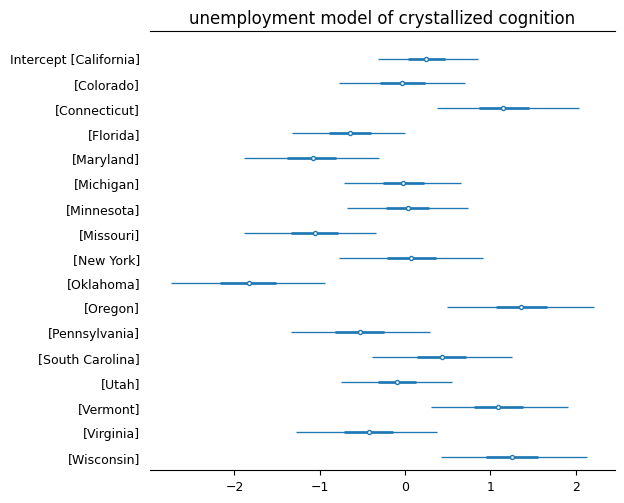

In [13]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("unemployment model of crystallized cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_unemp_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_52239/3893398295.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


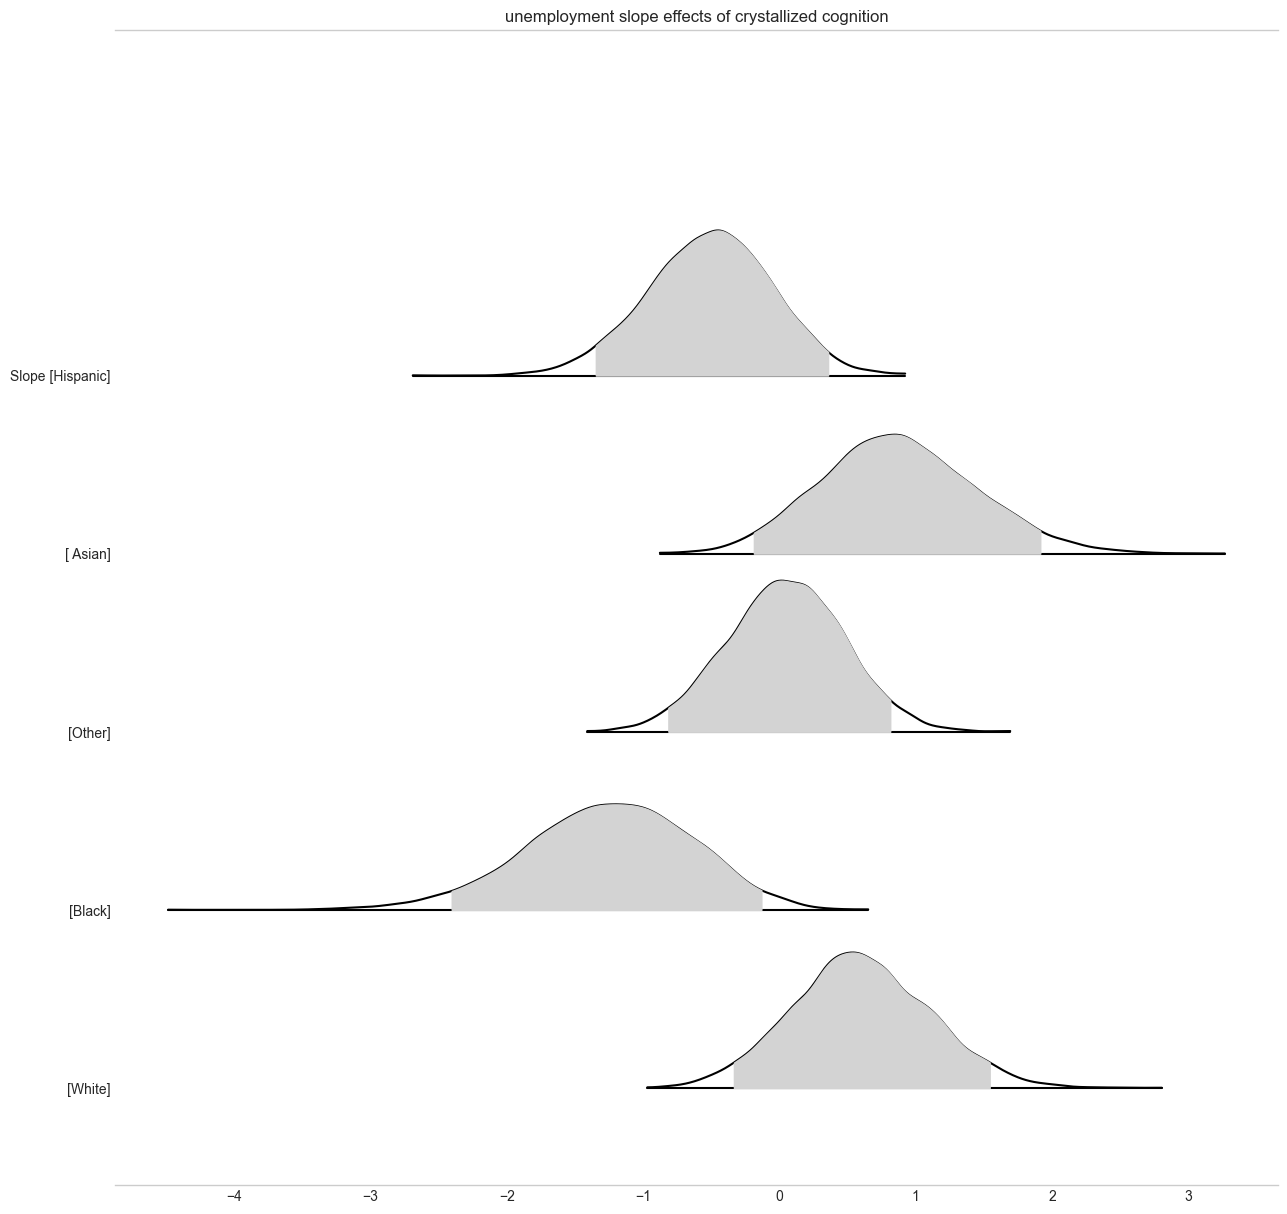

In [14]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("unemployment slope effects of crystallized cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_unemp_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [15]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [16]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.371537
r2_std    0.003568
dtype: float64

In [17]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [18]:
# get race, state and census unemployment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_unemp_df = pd.DataFrame(data['reshist_addr1_adi_unemp_bin'],columns =['reshist_addr1_adi_unemp_bin']).reset_index(drop=True)


In [19]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_unemp_df,ppc_df,left_index=True, right_index=True)


In [20]:
ppc_unemp_race_mean = (ppc_df.groupby(['reshist_addr1_adi_unemp_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_unemp_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.229122  0.345993  0.293798   
                            Black           0.291234  0.165807  0.253764   
                            Hispanic        0.214133  0.181523  0.260983   
                            Other           0.229717  0.241743  0.187501   
                            White           0.266584  0.285249  0.255365   
1.0                         Asian           0.412935  0.519990  0.335422   
                            Black          -0.779033 -0.814515 -0.887756   
                            Hispanic       -0.391270 -0.376811 -0.468237   
                            Other          -0.098497 -0.291191 -0.156437   
                            White           0.191645  0.131327  0.231134   

                                            pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.123076  0.208452  0.217592   
                            Black           0.165575  0.276483  0.151266   
                            Hispanic        0.226287  0.254267  0.238137   
                            Other           0.256884  0.225165  0.175330   
                            White           0.282501  0.287875  0.254818   
1.0                         Asian           0.448925  0.158900  0.307386   
                            Black          -0.841487 -0.799124 -0.856601   
                            Hispanic       -0.366372 -0.392910 -0.439765   
                            Other          -0.098029 -0.115585 -0.141476   
                            White           0.215348  0.211130  0.169032   

                                            pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.240752  0.243246  0.329530   
                            Black           0.279051  0.209602  0.311373   
                            Hispanic        0.217877  0.189036  0.267170   
                            Other           0.162395  0.154720  0.236850   
                            White           0.247156  0.276679  0.273558   
1.0                         Asian           0.209643  0.608677  0.190659   
                            Black          -0.869434 -0.838743 -0.890844   
                            Hispanic       -0.367856 -0.450641 -0.413019   
                            Other          -0.126083 -0.110142 -0.148354   
                            White           0.230656  0.168462  0.201845   

                                            pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_unemp_bin race_ethnicity            ...                
0.0                         Asian           0.241209  ...     0.192652   
                            Black           0.186842  ...     0.145653   
                            Hispanic        0.314723  ...     0.250355   
                            Other           0.195529  ...     0.216651   
                            White           0.280603  ...     0.247750   
1.0                         Asian           0.363824  ...     0.382395   
                            Black          -0.800195  ...    -0.856201   
                            Hispanic       -0.395895  ...    -0.418209   
                            Other          -0.195035  ...    -0.083935   
                            White           0.196840  ...     0.212310   

                                            pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_unemp_bin race_ethnicity                             
0.0                         Asian              0.194096     0.305187   
                            Black              0.238654     0.138821   
                            Hispanic           0.271435     0.258606   
                            Other              0.223834 

In [21]:
ppc_unemp_race_mean_summ=ppc_unemp_race_mean.mean(axis=1)
ppc_unemp_race_mean_summ

reshist_addr1_adi_unemp_bin  race_ethnicity
0.0                          Asian             0.270474
                             Black             0.207191
                             Hispanic          0.225091
                             Other             0.218551
                             White             0.253077
1.0                          Asian             0.370446
                             Black            -0.843704
                             Hispanic         -0.402330
                             Other            -0.132212
                             White             0.186828
dtype: float64

In [22]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.295046,0.408397,0.308727,0.239942,0.190680,0.249797,0.229595,0.374308,0.279724,0.285185,...,0.260703,0.265968,0.299359,0.227723,0.345758,0.570165,0.411435,0.313424,0.288824,0.168258
Black,-0.582082,-0.634115,-0.677693,-0.656167,-0.601190,-0.671132,-0.658089,-0.645825,-0.669611,-0.618560,...,-0.671839,-0.682411,-0.646758,-0.656223,-0.616211,-0.695207,-0.637919,-0.648163,-0.606145,-0.697875
Hispanic,-0.204075,-0.204170,-0.242756,-0.183117,-0.192798,-0.230153,-0.186743,-0.252848,-0.202700,-0.176167,...,-0.211484,-0.161011,-0.167335,-0.203728,-0.181717,-0.198285,-0.248263,-0.151303,-0.178418,-0.179748
Other,0.067786,-0.021190,0.017813,0.081781,0.057050,0.019028,0.020069,0.024045,0.046802,0.002837,...,0.068352,0.037496,0.087248,0.031549,0.064819,-0.016317,0.070367,-0.010457,0.010831,0.059775
White,0.240274,0.231209,0.246858,0.258925,0.260931,0.224700,0.241363,0.238686,0.248381,0.251195,...,0.235308,0.198632,0.226012,0.249587,0.222770,0.213446,0.210049,0.239027,0.206389,0.216443


In [23]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [24]:
ppc_unemp_state_mean = (ppc_df.groupby(['reshist_addr1_adi_unemp_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_unemp_state_mean_summ = ppc_unemp_state_mean.mean(axis=1)


In [25]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [26]:
ppc_unemp_state_mean_summ_list=ppc_unemp_state_mean_summ.to_numpy()
low_unemp_state = ppc_unemp_state_mean_summ_list[:17]
high_unemp_state = ppc_unemp_state_mean_summ_list[-17:]

In [27]:
mean_predictions_state = [low_unemp_state,high_unemp_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.280637,0.246732,0.393664,0.170831,0.11510,0.247109,0.253761,0.119236,0.258007,0.025127,0.418076,0.183791,0.302715,0.238303,0.383583,0.197916,0.403484
1,-0.214040,-0.143407,-0.090948,-0.388845,-0.62769,-0.187187,0.057245,-0.448151,-0.380237,-0.461810,0.180117,-0.517196,-0.184463,0.015665,0.254785,-0.384802,0.037271


In [28]:
ppc_unemp_race_mean_summ_list=ppc_unemp_race_mean_summ.to_numpy()
low_unemp_race = ppc_unemp_race_mean_summ_list[:5]
high_unemp_race = ppc_unemp_race_mean_summ_list[-5:]

In [29]:
# initialize list of lists 
mean_predictions_race = [low_unemp_race,high_unemp_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.270474,0.207191,0.225091,0.218551,0.253077
1,0.370446,-0.843704,-0.402330,-0.132212,0.186828


In [30]:
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','Nonemployed_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [31]:
val = census_data['Nonemployed_score'].median()
census_data.loc[census_data['Nonemployed_score'] < val, 'Nonemployed_score_bin'] = 0
census_data.loc[census_data['Nonemployed_score'] >= val, 'Nonemployed_score_bin'] = 1

In [32]:
census = (census_data.groupby(['state','race_ethnicity','Nonemployed_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Nonemployed_score_bin,freq
0,california,Asian,0.0,767423
1,california,Asian,1.0,1067892
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,5651418
...,...,...,...,...
138,wisconsin,Black,1.0,33831
139,wisconsin,Hispanic,0.0,88054
140,wisconsin,Other,0.0,183517
141,wisconsin,White,0.0,4177330


In [33]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Nonemployed_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,767423,1,0
1,california,Asian,1.0,1067892,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,5651418,0,0


In [34]:
#fix theano shared tensor type error
census=census.astype({'Nonemployed_score_bin':'uint8'})

In [35]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_unemp = census.Nonemployed_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
unemp_.set_value(ps_unemp)

In [36]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [37]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(143, 8000)

In [38]:
censust=census
censust

,state,race_ethnicity,Nonemployed_score_bin,freq,race_enc,state_enc
0,california,Asian,0,767423,1,0
1,california,Asian,1,1067892,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,5651418,0,0
...,...,...,...,...,...,...
138,wisconsin,Black,1,33831,3,16
139,wisconsin,Hispanic,0,88054,0,16
140,wisconsin,Other,0,183517,2,16
141,wisconsin,White,0,4177330,4,16


In [39]:
# get race, state, and census unemployment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_unemp_df2 = pd.DataFrame(censust['Nonemployed_score_bin'],columns =['Nonemployed_score_bin']).reset_index(drop=True)


In [40]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_unemp_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Nonemployed_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-1.504908,-0.023238,-0.220204,-0.673644,-0.904079,0.707098,...,0.809481,-0.116779,-1.443170,-1.790672,0.282917,-0.292934,-1.134960,2.260972,0.585185,-1.186699
1,california,Asian,1,1067892,0.699204,1.453717,0.792159,1.973282,-0.364272,1.106221,...,0.898088,0.305778,-1.114780,-1.088104,0.551556,-0.525451,0.676100,0.624352,-0.053229,-0.157789
2,california,Black,0,3168044,1.243055,1.936985,1.498122,0.391594,-0.172922,0.174519,...,-0.004292,-0.683903,-0.704861,2.306880,0.449746,0.501490,1.046704,0.173111,-0.006676,-0.195526
3,california,Black,1,786431,-0.044589,-0.609921,-1.507746,-0.530896,-1.992741,-1.513492,...,-0.930289,-0.875939,-1.474883,-1.204913,-0.191438,-0.491680,-0.726776,-0.172520,0.117581,-1.707805
4,california,Hispanic,0,5651418,-1.093785,-1.461886,0.318905,0.343344,-0.529326,-1.014359,...,0.202996,0.536930,-0.082982,-0.817937,0.385017,0.374089,1.401904,0.936767,1.352135,0.692508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,wisconsin,Black,1,33831,0.658252,-0.369109,-1.620059,-0.217391,-0.338614,-1.370881,...,-0.347057,-1.096425,-0.112469,-0.988594,0.715497,0.868923,-0.550956,-0.769566,-2.363109,-0.837758
139,wisconsin,Hispanic,0,88054,0.316952,1.002069,-1.106624,0.846017,0.689613,-0.019551,...,0.178661,0.576388,0.183875,-1.781231,1.497078,0.291320,2.514785,1.712748,-1.016895,0.601709
140,wisconsin,Other,0,183517,-0.268060,0.846071,0.928528,-0.264149,-0.786569,0.572898,...,-0.618758,-0.189007,1.083241,1.541662,0.135673,-0.191654,0.447733,-0.540506,-1.220294,1.285046
141,wisconsin,White,0,4177330,0.165309,0.567532,0.925292,0.592567,1.370521,1.604598,...,-0.155334,0.045269,-0.153344,1.372293,0.770226,2.836525,0.731861,1.065775,-0.307280,2.271377


In [41]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Nonemployed_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -1.154901e+06   
                          1                     1    7.466746e+05   
           Black          0                     2    3.938053e+06   
                          1                     3   -3.506590e+04   
           Hispanic       0                     4   -6.181435e+06   
...                                                           ...   
wisconsin  Black          1                     138  2.226933e+04   
           Hispanic       0                     139  2.790891e+04   
           Other          0                     140 -4.919348e+04   
           White          0                     141  6.905510e+05   
                          1                     142 -2.772450e+04   

                                                         pp_cog_1  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -1.783312e+04   
                          1                     1    1.552413e+06   
           Black          0                     2    6.136454e+06   
                          1                     3   -4.796605e+05   
           Hispanic       0                     4   -8.261731e+06   
...                                                           ...   
wisconsin  Black          1                     138 -1.248733e+04   
           Hispanic       0                     139  8.823620e+04   
           Other          0                     140  1.552685e+05   
           White          0                     141  2.370770e+06   
                          1                     142  3.132583e+04   

                                                         pp_cog_2  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -1.689898e+05   
                          1                     1    8.459406e+05   
           Black          0                     2    4.746117e+06   
                          1                     3   -1.185738e+06   
           Hispanic       0                     4    1.802266e+06   
...                                                           ...   
wisconsin  Black          1                     138 -5.480820e+04   
           Hispanic       0                     139 -9.744266e+04   
           Other          0                     140  1.704007e+05   
           White          0                     141  3.865251e+06   
                          1                     142  2.965035e+04   

                                                         pp_cog_3  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -5.169700e+05   
                          1                     1    2.107252e+06   
           Black          0                     2    1.240588e+06   
                          1                     3   -4.175134e+05   
           Hispanic       0                     4    1.940380e+06   
...                                                           ...   
wisconsin  Black          1                     138 -7.354553e+03   
           Hispanic       0                     139  7.449516e+04   
           Other          0                     140 -4.847585e+04   
           White          0                     141  2.475346e+06   
                          1                     142  6.602527e+04   

                                                         pp_cog_4  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -6.938113e+05   
                          1                     1   -3.890035e+05   
           Black          0                     2   -5.478250e+05   
                          1                     3   -1.567153e+06   
           Hispanic       0                     4  

In [42]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-1.154901e+06,-1.783312e+04,-1.689898e+05,-5.169700e+05,-6.938113e+05,5.426435e+05,-2.923160e+05,9.279845e+05,3.428876e+05,-7.075977e+05,...,6.212147e+05,-8.961871e+04,-1.107522e+06,-1.374203e+06,2.171167e+05,-2.248042e+05,-8.709945e+05,1.735122e+06,4.490846e+05,-9.107000e+05
1,7.466746e+05,1.552413e+06,8.459406e+05,2.107252e+06,-3.890035e+05,1.181325e+06,1.275597e+06,-8.899030e+05,-4.012912e+05,-5.427359e+04,...,9.590613e+05,3.265374e+05,-1.190464e+06,-1.161978e+06,5.890023e+05,-5.611247e+05,7.220022e+05,6.667407e+05,-5.684326e+04,-1.685017e+05
2,3.938053e+06,6.136454e+06,4.746117e+06,1.240588e+06,-5.478250e+05,5.528840e+05,8.392537e+05,4.398897e+05,1.326969e+06,-1.096302e+06,...,-1.359744e+04,-2.166633e+06,-2.233031e+06,7.308298e+06,1.424814e+06,1.588743e+06,3.316004e+06,5.484228e+05,-2.115139e+04,-6.194336e+05
3,-3.506590e+04,-4.796605e+05,-1.185738e+06,-4.175134e+05,-1.567153e+06,-1.190257e+06,-7.760786e+05,-4.274968e+05,-2.070083e+06,-1.606991e+06,...,-7.316079e+05,-6.888656e+05,-1.159894e+06,-9.475811e+05,-1.505528e+05,-3.866728e+05,-5.715595e+05,-1.356747e+05,9.246972e+04,-1.343071e+06
4,-6.181435e+06,-8.261731e+06,1.802266e+06,1.940380e+06,-2.991444e+06,-5.732569e+06,1.389549e+07,-2.239623e+06,3.885898e+06,-6.160995e+06,...,1.147213e+06,3.034418e+06,-4.689656e+05,-4.622505e+06,2.175890e+06,2.114135e+06,7.922748e+06,5.294060e+06,7.641480e+06,3.913650e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2.226933e+04,-1.248733e+04,-5.480820e+04,-7.354553e+03,-1.145564e+04,-4.637828e+04,-2.573835e+04,-3.048221e+04,-6.766942e+04,1.139426e+04,...,-1.174127e+04,-3.709314e+04,-3.804947e+03,-3.344514e+04,2.420598e+04,2.939655e+04,-1.863939e+04,-2.603520e+04,-7.994634e+04,-2.834219e+04
139,2.790891e+04,8.823620e+04,-9.744266e+04,7.449516e+04,6.072315e+04,-1.721526e+03,2.436483e+04,5.173495e+04,-6.680102e+04,6.546684e+04,...,1.573182e+04,5.075323e+04,1.619093e+04,-1.568446e+05,1.318237e+05,2.565187e+04,2.214369e+05,1.508143e+05,-8.954167e+04,5.298292e+04
140,-4.919348e+04,1.552685e+05,1.704007e+05,-4.847585e+04,-1.443488e+05,1.051365e+05,-5.772655e+04,2.090546e+05,2.369659e+05,2.752827e+05,...,-1.135526e+05,-3.468593e+04,1.987931e+05,2.829211e+05,2.489830e+04,-3.517181e+04,8.216661e+04,-9.919213e+04,-2.239446e+05,2.358278e+05
141,6.905510e+05,2.370770e+06,3.865251e+06,2.475346e+06,5.725117e+06,6.702936e+06,4.512701e+06,3.715140e+06,4.627005e+06,4.840088e+05,...,-6.488829e+05,1.891022e+05,-6.405668e+05,5.732521e+06,3.217489e+06,1.184910e+07,3.057225e+06,4.452093e+06,-1.283608e+06,9.488290e+06


In [43]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Nonemployed_score_bin,freq
0,california,Asian,0,767423
1,california,Asian,1,1067892
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,5651418
...,...,...,...,...
138,wisconsin,Black,1,33831
139,wisconsin,Hispanic,0,88054
140,wisconsin,Other,0,183517
141,wisconsin,White,0,4177330


In [44]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Nonemployed_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-1.154901e+06,-1.783312e+04,-1.689898e+05,-5.169700e+05,-6.938113e+05,5.426435e+05,...,6.212147e+05,-8.961871e+04,-1.107522e+06,-1.374203e+06,2.171167e+05,-2.248042e+05,-8.709945e+05,1.735122e+06,4.490846e+05,-9.107000e+05
1,california,Asian,1,1067892,7.466746e+05,1.552413e+06,8.459406e+05,2.107252e+06,-3.890035e+05,1.181325e+06,...,9.590613e+05,3.265374e+05,-1.190464e+06,-1.161978e+06,5.890023e+05,-5.611247e+05,7.220022e+05,6.667407e+05,-5.684326e+04,-1.685017e+05
2,california,Black,0,3168044,3.938053e+06,6.136454e+06,4.746117e+06,1.240588e+06,-5.478250e+05,5.528840e+05,...,-1.359744e+04,-2.166633e+06,-2.233031e+06,7.308298e+06,1.424814e+06,1.588743e+06,3.316004e+06,5.484228e+05,-2.115139e+04,-6.194336e+05
3,california,Black,1,786431,-3.506590e+04,-4.796605e+05,-1.185738e+06,-4.175134e+05,-1.567153e+06,-1.190257e+06,...,-7.316079e+05,-6.888656e+05,-1.159894e+06,-9.475811e+05,-1.505528e+05,-3.866728e+05,-5.715595e+05,-1.356747e+05,9.246972e+04,-1.343071e+06
4,california,Hispanic,0,5651418,-6.181435e+06,-8.261731e+06,1.802266e+06,1.940380e+06,-2.991444e+06,-5.732569e+06,...,1.147213e+06,3.034418e+06,-4.689656e+05,-4.622505e+06,2.175890e+06,2.114135e+06,7.922748e+06,5.294060e+06,7.641480e+06,3.913650e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,wisconsin,Black,1,33831,2.226933e+04,-1.248733e+04,-5.480820e+04,-7.354553e+03,-1.145564e+04,-4.637828e+04,...,-1.174127e+04,-3.709314e+04,-3.804947e+03,-3.344514e+04,2.420598e+04,2.939655e+04,-1.863939e+04,-2.603520e+04,-7.994634e+04,-2.834219e+04
139,wisconsin,Hispanic,0,88054,2.790891e+04,8.823620e+04,-9.744266e+04,7.449516e+04,6.072315e+04,-1.721526e+03,...,1.573182e+04,5.075323e+04,1.619093e+04,-1.568446e+05,1.318237e+05,2.565187e+04,2.214369e+05,1.508143e+05,-8.954167e+04,5.298292e+04
140,wisconsin,Other,0,183517,-4.919348e+04,1.552685e+05,1.704007e+05,-4.847585e+04,-1.443488e+05,1.051365e+05,...,-1.135526e+05,-3.468593e+04,1.987931e+05,2.829211e+05,2.489830e+04,-3.517181e+04,8.216661e+04,-9.919213e+04,-2.239446e+05,2.358278e+05
141,wisconsin,White,0,4177330,6.905510e+05,2.370770e+06,3.865251e+06,2.475346e+06,5.725117e+06,6.702936e+06,...,-6.488829e+05,1.891022e+05,-6.405668e+05,5.732521e+06,3.217489e+06,1.184910e+07,3.057225e+06,4.452093e+06,-1.283608e+06,9.488290e+06


In [45]:
#final step of poststratification - by race & unemp 
#data-weighted average
ppc_unemp_race_poststrat = ppc_poststrat_df.groupby(['Nonemployed_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_unemp_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  pp_cog_3  \
Nonemployed_score_bin race_ethnicity                                           
0                     Asian           0.155007 -0.092556  0.401761 -0.081626   
                      Black           0.422488  0.471059  0.540333  0.578639   
                      Hispanic       -0.396858  0.408419  0.385393  0.487792   
                      Other           0.113275 -0.251240  0.330585  0.106843   
                      White           0.351174  1.092899 -0.184977  0.264071   
1                     Asian           0.765938  1.314129  0.812001  0.821080   
                      Black          -0.548536 -0.910221 -0.482898 -1.195226   
                      Hispanic       -1.080045 -0.039689  0.124917 -0.504663   
                      Other          -0.299521 -0.076124 -0.787041 -0.006329   
                      White           0.339153 -0.037713 -0.313716 -0.000151   

                                      pp_cog_4  pp_cog_5  pp_cog_6  pp_cog_7  \
Nonemployed_score_bin race_ethnicity                                           
0                     Asian           0.604919 -0.584646 -0.775659 -0.196004   
                      Black           0.526068  0.095024  0.604354  0.579575   
                      Hispanic        0.087541  0.434247  0.697951  0.311350   
                      Other          -0.263403  0.583532 -0.565720 -0.039351   
                      White           0.502441  0.226784  0.392243  0.425739   
1                     Asian           0.154212  0.301196  0.480181  0.851709   
                      Black          -0.918930 -1.443563 -1.392467 -0.782973   
                      Hispanic       -0.196787 -0.622698 -1.147915 -0.002925   
                      Other          -0.381406  0.245139 -0.589872 -0.846050   
                      White          -0.030320  0.705820  0.434907  0.550414   

                                      pp_cog_8  pp_cog_9  ...  pp_cog_7990  \
Nonemployed_score_bin race_ethnicity                      ...                
0                     Asian           0.860293 -0.070763  ...     0.157824   
                      Black          -0.295022 -0.133954  ...     0.213389   
                      Hispanic        0.462106 -0.237017  ...     1.218093   
                      Other           0.371559  0.799442  ...    -0.141715   
                      White           0.425119  0.671107  ...     0.060941   
1                     Asian           0.312194 -0.414409  ...     0.426772   
                      Black          -1.057601 -1.170195  ...    -1.274305   
                      Hispanic        0.049226 -1.022658  ...    -0.740591   
                      Other           0.000955  0.427216  ...    -0.144680   
                      White           0.635149 -0.141370  ...     0.371719   

                                      pp_cog_7991  pp_cog_7992  pp_cog_7993  \
Nonemployed_score_bin race_ethnicity                                          
0                     Asian             -0.315369     0.179951    -0.496368   
                      Black              0.197495    -0.373980     0.695426   
                      Hispanic           0.389786     0.109207     0.023170   
                      Other              0.097692    -0.187316     0.325107   
                      White              0.823285     0.485022    -0.308233   
1                     Asian              0.331939    -0.033205    -0.377560   
                      Black             -1.172229    -1.173799    -0.764307   
                      Hispanic           0.319160    -0.620060    -0.307038   
                      Other             -0.455459    -0.486167     0.609234   
                      White              0.320507    -0.356442    -0.108624   

                                      pp_cog_7994  pp_cog_7995  pp_cog_7996  \
Nonemployed_score_bin race_ethnicity                                          
0                     Asian              0.596419     0.076042     0.619

In [46]:
#summarize race & unemp poststrat results
ppc_unemp_race_poststrat_summ = ppc_unemp_race_poststrat.mean(axis=1)
ppc_unemp_race_poststrat_summ

Nonemployed_score_bin  race_ethnicity
0                      Asian             0.236456
                       Black             0.226124
                       Hispanic          0.226683
                       Other             0.194193
                       White             0.264756
1                      Asian             0.293707
                       Black            -0.828139
                       Hispanic         -0.399162
                       Other            -0.140196
                       White             0.164973
dtype: float64

In [47]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.250849
Black       0.000420
Hispanic    0.048006
Other      -0.038212
White       0.232539
dtype: float64

In [48]:
#for the lollipops
#final step poststrat - by state & unemp
ppc_unemp_state_poststrat = ppc_poststrat_df.groupby(['Nonemployed_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_unemp_state_poststrat_summ = ppc_unemp_state_poststrat.mean(axis=1)
ppc_unemp_state_poststrat_summ

Nonemployed_score_bin  state        
0                      california       0.279512
                       colorado         0.257388
                       connecticut      0.391466
                       florida          0.173008
                       maryland         0.115642
                       michigan         0.248965
                       minnesota        0.260549
                       missouri         0.134247
                       newyork          0.268479
                       oklahoma         0.031947
                       oregon           0.415637
                       pennsylvania     0.196580
                       southcarolina    0.298075
                       utah             0.237723
                       vermont          0.390277
                       virginia         0.193694
                       wisconsin        0.411472
1                      california      -0.048596
                       colorado        -0.172066
                       florida  

In [49]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.167546
colorado         0.221453
connecticut      0.391466
florida          0.022731
maryland        -0.038946
michigan         0.159325
minnesota        0.259182
missouri         0.061571
newyork          0.160168
oklahoma        -0.051399
oregon           0.320512
pennsylvania     0.148615
southcarolina    0.138286
utah             0.226781
vermont          0.389385
virginia         0.134703
wisconsin        0.403990
dtype: float64

In [50]:
ppc_unemp_state_poststrat_summ_list=ppc_unemp_state_poststrat_summ.tolist()

In [51]:
#fill in missing value for connecticut
ppc_unemp_state_poststrat_summ_list.insert(19,ppc_unemp_state_mean_summ.iloc[19])

In [53]:
low_unemp_state_poststrat = ppc_unemp_state_poststrat_summ_list[:17]
high_unemp_state_poststrat = ppc_unemp_state_poststrat_summ_list[-17:]

In [54]:
ppc_unemp_race_poststrat_summ_list=ppc_unemp_race_poststrat_summ.tolist()

In [55]:
low_unemp_race_poststrat = ppc_unemp_race_poststrat_summ_list[:5]
high_unemp_race_poststrat = ppc_unemp_race_poststrat_summ_list[-5:]

In [56]:
mean_predictions_state_ps = [low_unemp_state_poststrat,high_unemp_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.279512,0.257388,0.391466,0.173008,0.115642,0.248965,0.260549,0.134247,0.268479,0.031947,0.415637,0.196580,0.298075,0.237723,0.390277,0.193694,0.411472
1,-0.048596,-0.172066,-0.090948,-0.176588,-0.854726,0.066251,0.110171,-0.155000,-0.033673,-0.161005,0.227009,0.041128,-0.013640,0.062051,0.300491,-0.052472,0.014519


In [57]:
# initialize list of lists 
mean_predictions_race_ps = [low_unemp_race_poststrat,high_unemp_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.236456,0.226124,0.226683,0.194193,0.264756
1,0.293707,-0.828139,-0.399162,-0.140196,0.164973


In [58]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([-0.04767848777111288,
  0.12893263372217742,
  0.11088212395453217,
  -0.23289465707827578,
  -0.2275008598781279,
  -0.0004549726779985546,
  0.20703631761928037,
  -0.20865430393788986,
  0.01865725045798004,
  -0.16559918704943896,
  0.260588614434346,
  -0.3933314676437747,
  0.03450460521263984,
  0.1802656742857983,
  0.3576134910276689,
  -0.05840323833916357,
  0.3003939169832514],
 [0.17132561621887732,
  0.2232572320573633,
  0.39244827764727414,
  0.020916015135931255,
  -0.046393918785722146,
  0.158742196248727,
  0.2645075115412914,
  0.06453943926923927,
  0.16231831887453224,
  -0.051328614880781845,
  0.3186122346956945,
  0.1513776191804265,
  0.1341082695521254,
  0.23021015405006218,
  0.39186557395269506,
  0.13160451282006944,
  0.40079471151123247])

In [59]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

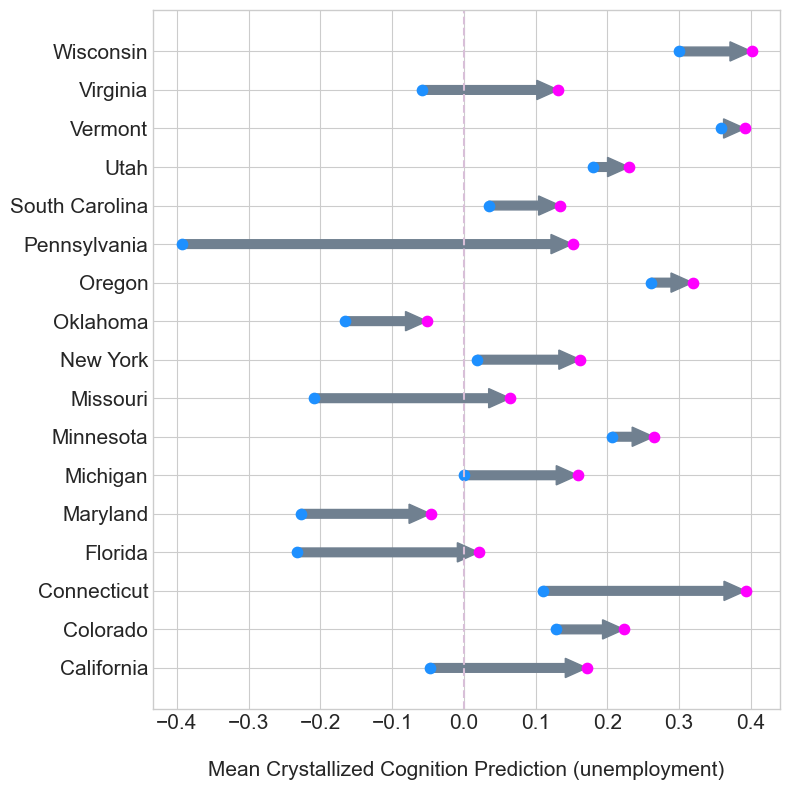

In [60]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (unemployment)',size=15,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Unemployment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_unemp_crystallized_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [61]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.3061347770190799,
  -0.6501166878563275,
  -0.20839218967943401,
  0.04613357748974697,
  0.22978577636873027],
 [0.2530497571513204,
  -0.00033232208448715536,
  0.050899648087519504,
  -0.03897409191049854,
  0.23027318661808038])

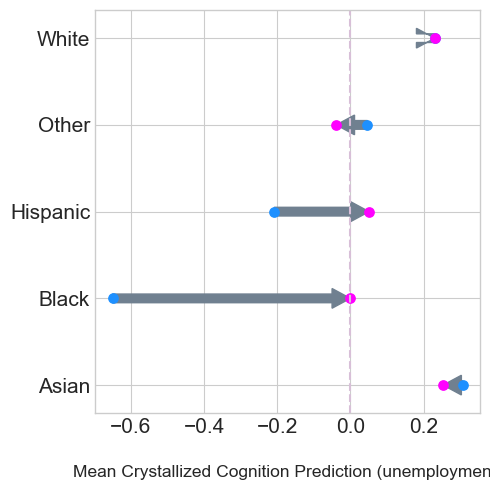

In [62]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (unemployment)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Unemployment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_unemp_crystallized_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_52239/3383021607.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_52239/3383021607.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


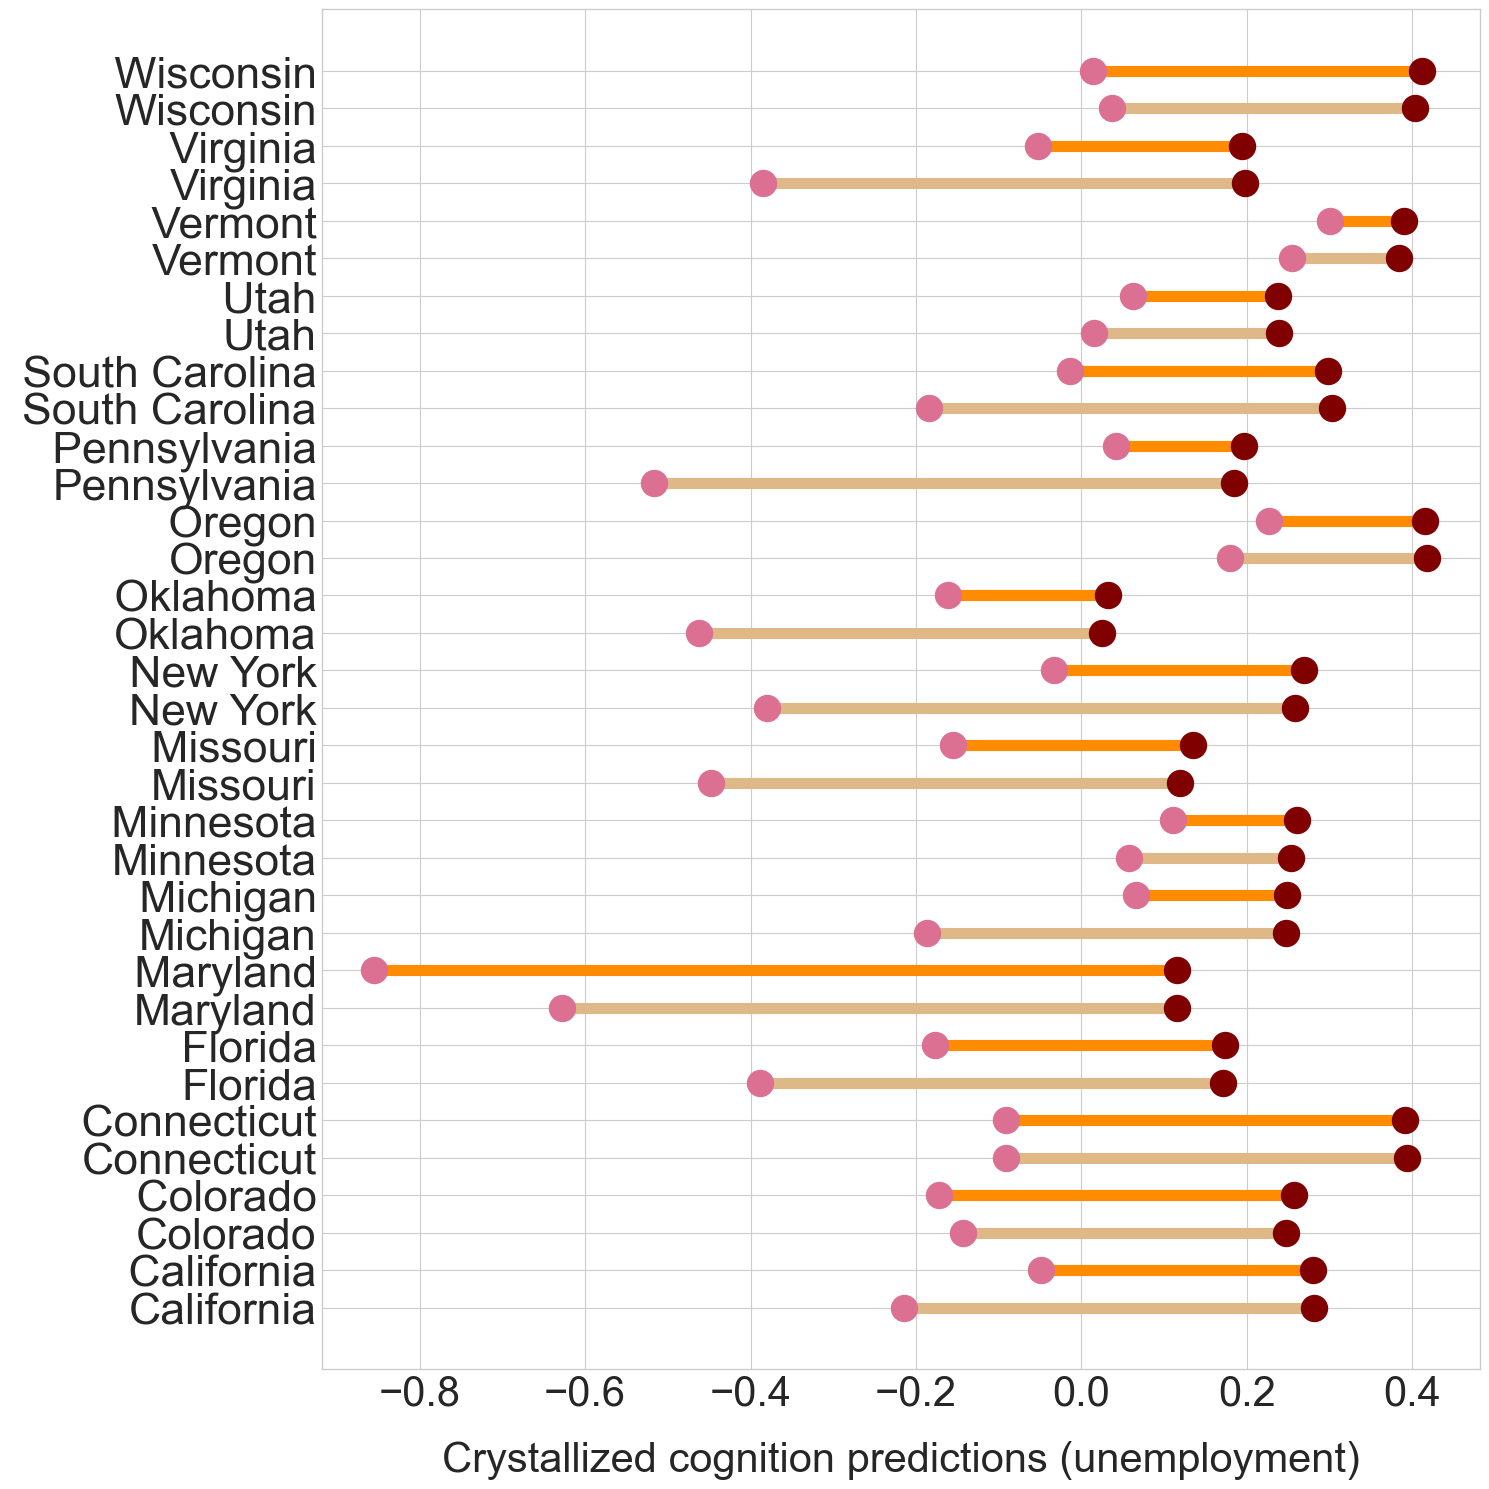

In [63]:
#low_state_edu2,high_state_edu2,low_state_edu,high_state_edu
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='maroon', label='low unemp', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='palevioletred', label='high unemp', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='maroon', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='palevioletred', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (unemployment)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low unemp', 'high unemp'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_unemp_crystallized_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_52239/1784794093.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_52239/1784794093.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


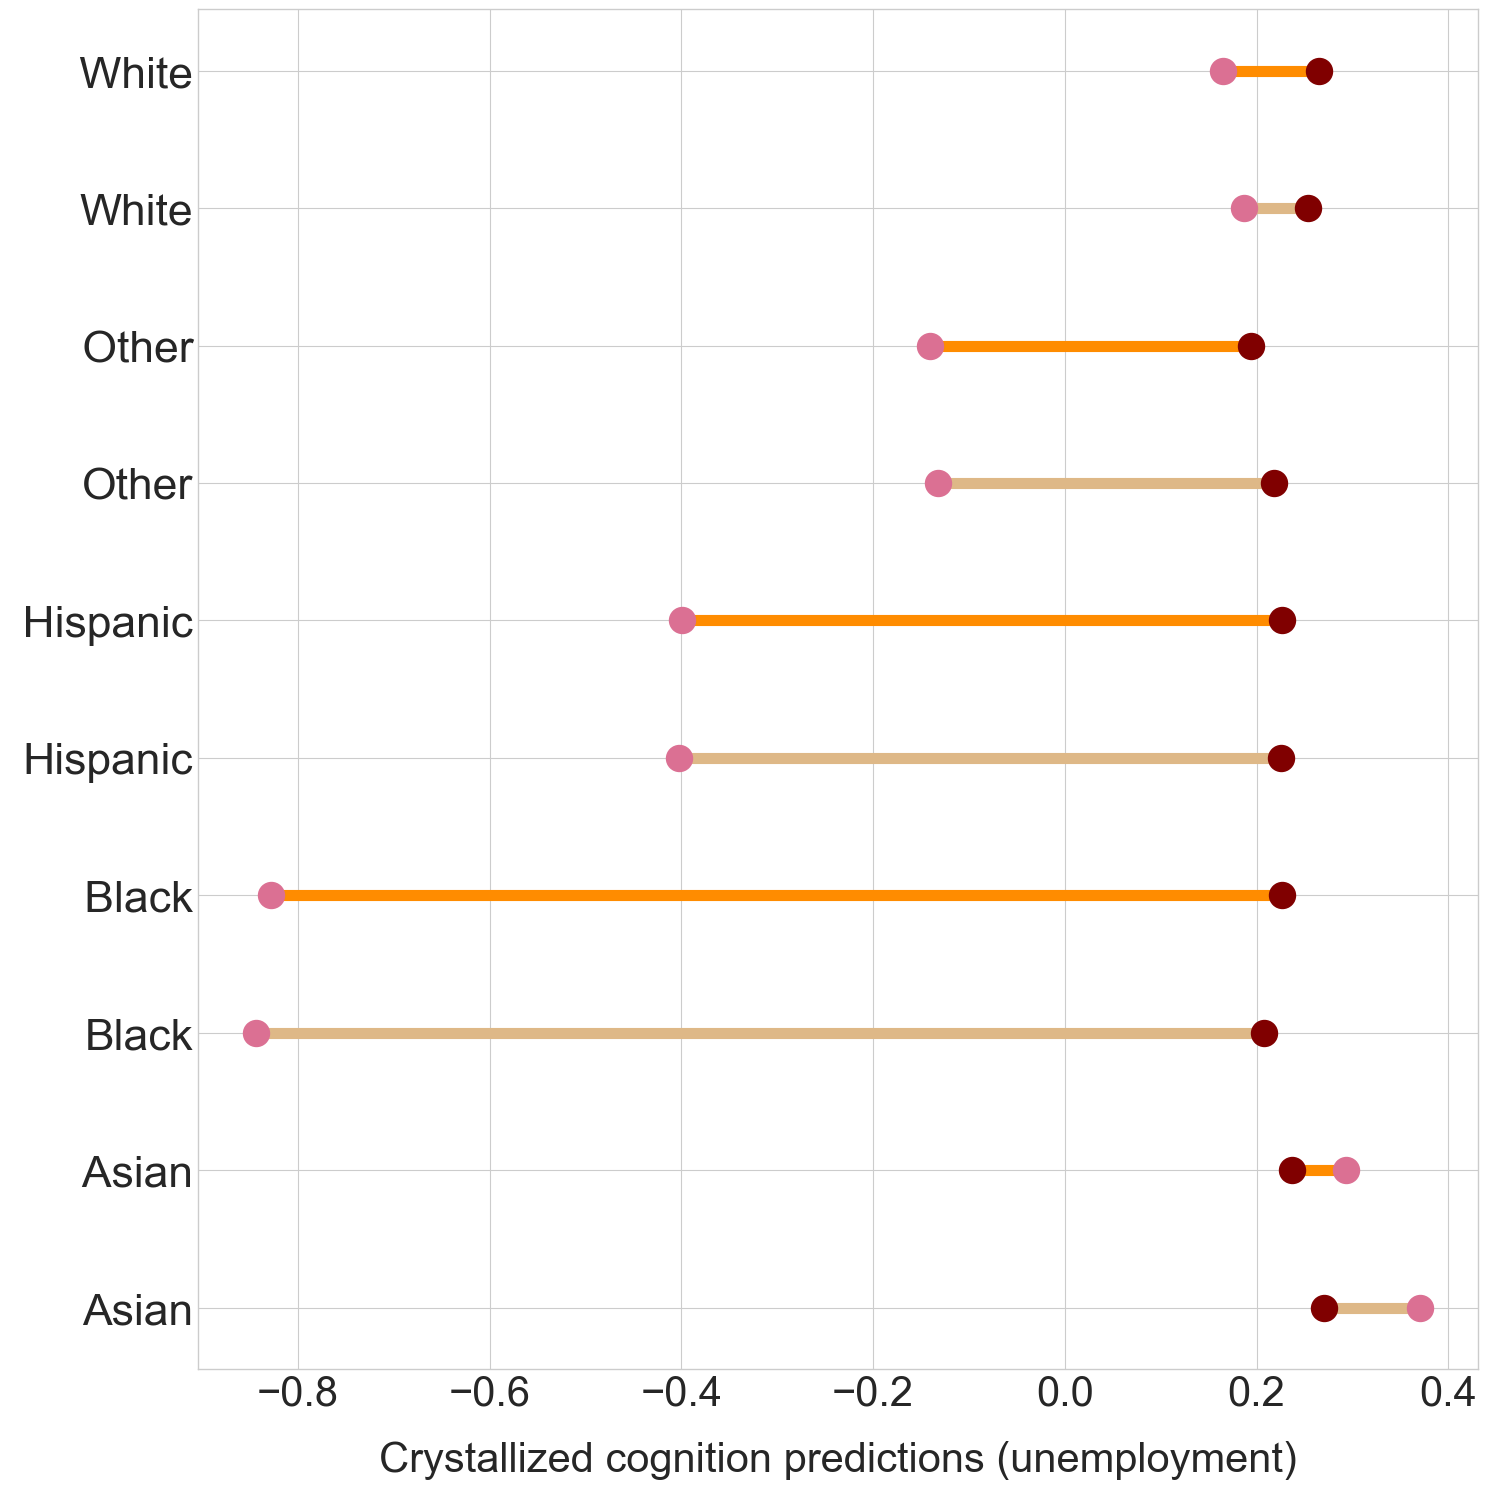

In [64]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='maroon', label='low unemp', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='palevioletred', label='high unemp', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='maroon', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='palevioletred', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (unemployment)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low unemp', 'high unemp'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_unemp_crystallized_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()